# Domain rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
g = threatgraph.Gaffer()
g.use_cert()

In [3]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
             gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    thing = list(ent["entities"][3].keys())[0]
    
    k = (dev, thing)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in things:
        things[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    things[dev].add(thing)
    all_things.add(thing)
    all_devices.add(dev)

In [23]:
all_devices = list(all_devices)
all_things = list(all_things)

## Construct domain to device matrix

In [26]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)

# Add a score column
df["score"] = df.sum(axis=1)
df

,boundless-mac,steamverne-mac,turing-minimacbook,essential-chrome,turing-chromebook,tirasse-mac,castle3b7c9f,simon-macpro,terrestrial-mac,turing-macbook,...,misskitty-mac,elysium-mac,DESKTOP-PIMD8C0,dramatic-mac,essential-mac,abroad-android,LAPTOP-1I501C4U,dgmac,daniel-chromebook,score
contensis.com,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
tplighting.hk,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,2
customer.io,0,0,0,0,0,0,0,0,0,0,...,18,0,0,0,0,0,0,0,0,22
ipvoid.com,0,0,0,0,0,0,0,0,0,0,...,39,0,0,0,0,0,0,0,0,52
otdreport.com,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
auth.oauth2,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,2
ksonnet.io,0,0,0,0,0,0,0,0,3,0,...,2,0,0,0,0,0,0,0,0,5
gexperiments1.com,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
belbex.com,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
stylosophy.it,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


## Get list of highest accessed domains by all devices

In [27]:
n = 100
tops = 1000
top_domains = df.sort_values(by="score", ascending=False).index.values[:tops]
top_domains

array(['google.com', 'gstatic.com', 'trustnetworks.com', 'googleapis.com',
       'apple.com', 'in-addr.arpa', 'clubhouse.io', 'akadns.net',
       'doubleclick.net', 'netgear.com', 'slack.com', 'amazonaws.com',
       'googleusercontent.com', 'github.com', 'facebook.com',
       'akamaiedge.net', 'google.co.uk', 'icloud.com', 'microsoft.com',
       'apple-dns.net', 'virustotal.com', 'amazon.com', 'rbxcdn.com',
       'cloudapp.net', 'utun1.viscosity', 'codeanywhere.com',
       'utun2.viscosity', 'cloudfront.net', 'google-analytics.com',
       'adnxs.com', 'bbc.co.uk', 'ea.com', 'adsafeprotected.com',
       'slack-edge.com', 'skype.com', 'githubusercontent.com',
       'linkedin.com', 'googlesyndication.com', 'intercom.io',
       'hubspot.com', 'slack-msgs.com', 'fastly.net', 'ddns.net',
       'bbci.co.uk', 'trafficmanager.net', 'pubmatic.com',
       'doubleverify.com', 'gravatar.com', 'azureedge.net', 'twitter.com',
       'imrworldwide.com', 'gvt2.com', 'quantserve.com', 'orig

## Construct inverted index of domain to ranking
e.g. google.com is the most common domain, its rank is 0.  Next is gstatic.com. its rank is 1.

In [28]:
top_map = {top_domains[i]: i for i in range(0, len(top_domains)) }
top_map

{'google.com': 0,
 'gstatic.com': 1,
 'trustnetworks.com': 2,
 'googleapis.com': 3,
 'apple.com': 4,
 'in-addr.arpa': 5,
 'clubhouse.io': 6,
 'akadns.net': 7,
 'doubleclick.net': 8,
 'netgear.com': 9,
 'slack.com': 10,
 'amazonaws.com': 11,
 'googleusercontent.com': 12,
 'github.com': 13,
 'facebook.com': 14,
 'akamaiedge.net': 15,
 'google.co.uk': 16,
 'icloud.com': 17,
 'microsoft.com': 18,
 'apple-dns.net': 19,
 'virustotal.com': 20,
 'amazon.com': 21,
 'rbxcdn.com': 22,
 'cloudapp.net': 23,
 'utun1.viscosity': 24,
 'codeanywhere.com': 25,
 'utun2.viscosity': 26,
 'cloudfront.net': 27,
 'google-analytics.com': 28,
 'adnxs.com': 29,
 'bbc.co.uk': 30,
 'ea.com': 31,
 'adsafeprotected.com': 32,
 'slack-edge.com': 33,
 'skype.com': 34,
 'githubusercontent.com': 35,
 'linkedin.com': 36,
 'googlesyndication.com': 37,
 'intercom.io': 38,
 'hubspot.com': 39,
 'slack-msgs.com': 40,
 'fastly.net': 41,
 'ddns.net': 42,
 'bbci.co.uk': 43,
 'trafficmanager.net': 44,
 'pubmatic.com': 45,
 'double

## Get favourite domains by device

In [29]:
fav_domains = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_domains

[['boundless-mac',
  array(['google.com', 'in-addr.arpa', 'apple.com', 'clubhouse.io',
         'gstatic.com', 'codeanywhere.com', 'amazonaws.com', 'slack.com',
         'intercom.io', 'googleapis.com', 'doubleclick.net', 'akadns.net',
         'amazon.com', 'google.co.uk', 'utun2.viscosity', 'utun1.viscosity',
         'github.com', 'googleusercontent.com', 'utun0.viscosity',
         'trustnetworks.com', 'slack-edge.com', 'icloud.com',
         'githubusercontent.com', 'akamaiedge.net', 'slack-msgs.com',
         'gravatar.com', 'adsafeprotected.com', 'aaplimg.com',
         'salesforceliveagent.com', 'apple-dns.net', 'firebaseio.com',
         'sparklabs.com', 'googlesyndication.com', 'stackoverflow.com',
         'cloudfront.net', 'google-analytics.com', 'slack-imgs.com',
         'hosted-by-discourse.com', 'quantserve.com', 'scotch.io',
         'twitter.com', 'doubleverify.com', 'facebook.com', 'trello.com',
         '2mdn.net', 'visitors.live', 'rubiconproject.com', 'docker.com'

In [30]:
df2 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
df2

,domains
device,
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous..."
steamverne-mac,"[google.com, doubleclick.net, gstatic.com, goo..."
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar..."
essential-chrome,"[google.com, clubhouse.io, googleapis.com, sla..."
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac..."
tirasse-mac,"[google.com, in-addr.arpa, gstatic.com, clubho..."
castle3b7c9f,"[netgear.com, contensis.com, alignedleft.com, ..."
simon-macpro,"[google.com, gstatic.com, akadns.net, apple.co..."
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi..."


## Construct a column mapping device to ranking vector
The vector contains maps the most visited domains by device (e.g. ["google.com", "apple.com", "not.foiund"], to a vector with a ranking for each domain e.g. [0, 4, 1000]

In [54]:
get_rank = lambda d: top_map[d] if d in top_map else tops

In [55]:
[ get_rank(v) for v in ["google.com", "apple.com", "not.found"] ]

[0, 4, 1000]

In [56]:
df2["rank"] = df2["domains"].apply(lambda x: [ get_rank(v) for  v in x ])
df2[["rank"]]

,rank
device,
boundless-mac,"[0, 5, 4, 6, 1, 25, 11, 10, 38, 3, 8, 7, 21, 1..."
steamverne-mac,"[0, 8, 1, 3, 6, 29, 50, 5, 37, 32, 11, 16, 10,..."
turing-minimacbook,"[0, 4, 7, 5, 19, 1, 3, 12, 15, 17, 24, 14, 65,..."
essential-chrome,"[0, 6, 3, 10, 1, 21, 2, 30, 36, 124, 87, 43, 1..."
turing-chromebook,"[0, 3, 1, 10, 12, 39, 43, 30, 77, 97, 108, 4, ..."
tirasse-mac,"[0, 5, 1, 6, 4, 3, 13, 7, 12, 10, 24, 16, 283,..."
castle3b7c9f,"[9, 1000, 1000, 1000, 1000, 1000, 1000, 1000, ..."
simon-macpro,"[0, 1, 7, 4, 3, 19, 12, 5, 10, 36, 17, 15, 278..."
terrestrial-mac,"[0, 1, 4, 3, 5, 21, 11, 12, 10, 6, 8, 27, 36, ..."


## Compute Spearman co-efficient
against most common domains

In [57]:
def coefficient(x):
    tot = 0
    for i in range(0, n):
        tot += (x[i] - i) * (x[i] - i)
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

df2["coefficient"] = df2["rank"].apply(coefficient).round(2)

In [58]:
df2.sort_values(by="coefficient", ascending=False)[["domains", "coefficient"]]

,domains,coefficient
device,,
minesweepers-mac,"[google.com, github.com, in-addr.arpa, apple.c...",-1.33
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat...",-1.70
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",-2.37
steamverne-mac,"[google.com, doubleclick.net, gstatic.com, goo...",-3.14
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous...",-7.89
dramatic-mac,"[google.com, apple.com, rbxcdn.com, in-addr.ar...",-14.11
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic....",-16.66
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",-16.92
nervings-cb,"[google.com, clubhouse.io, googleapis.com, gst...",-21.12


## Device to device co-efficient

In [59]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:tops][v].index.values] for v in all_devices ]

In [60]:
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")

In [61]:
for dev, domains in everyone:
    dev_domains = domains
    dd_map = {dev_domains[i]: i for i in range(0, len(dev_domains)) }
    get_rank = lambda d: dd_map[d] if d in dd_map else len(dev_domains) + 1
    rankv = df3["domains"].apply(lambda x: [ get_rank(v) for  v in x ])
    df3[dev] = rankv.apply(coefficient).round(2)

In [62]:
df3

,domains,boundless-mac,steamverne-mac,turing-minimacbook,essential-chrome,turing-chromebook,tirasse-mac,castle3b7c9f,simon-macpro,terrestrial-mac,...,ludicrous-mac,misskitty-mac,elysium-mac,DESKTOP-PIMD8C0,dramatic-mac,essential-mac,abroad-android,LAPTOP-1I501C4U,dgmac,daniel-chromebook
device,,,,,,,,,,,,,,,,,,,,,
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous...",1.00,-106.85,-162.08,-256.21,-245.19,-146.26,-474.35,-179.52,-83.66,...,-323.92,-59.67,-153.71,-243.38,-207.48,-435.37,-268.06,-243.38,-290.78,-338.38
steamverne-mac,"[google.com, doubleclick.net, gstatic.com, goo...",-93.36,1.00,-183.85,-279.66,-293.31,-165.14,-485.01,-207.92,-112.78,...,-391.94,-53.57,-152.94,-169.66,-181.54,-450.94,-284.24,-169.66,-339.43,-410.17
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar...",-156.96,-144.28,1.00,-255.00,-118.52,-188.48,-489.13,-84.44,-96.60,...,-314.29,-116.25,-108.55,-265.41,-177.84,-432.89,-356.35,-265.41,-333.40,-341.38
essential-chrome,"[google.com, clubhouse.io, googleapis.com, sla...",-139.08,-90.94,-134.70,1.00,-211.71,-167.14,-501.00,-144.10,-96.65,...,-390.07,-104.01,-136.15,-163.37,-204.00,-472.38,-289.06,-163.37,-324.33,-382.27
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac...",-210.44,-133.33,-83.87,-193.69,1.00,-197.80,-501.17,-78.88,-134.34,...,-337.81,-121.09,-150.68,-255.19,-215.68,-444.26,-347.40,-255.19,-333.58,-329.10
tirasse-mac,"[google.com, in-addr.arpa, gstatic.com, clubho...",-132.44,-105.86,-167.63,-273.38,-222.14,1.00,-472.68,-201.80,-159.17,...,-340.00,-73.42,-207.32,-264.39,-253.05,-427.58,-349.58,-264.39,-213.96,-359.65
castle3b7c9f,"[netgear.com, contensis.com, alignedleft.com, ...",-500.14,-503.91,-210.28,-61.71,-49.50,-148.56,1.00,-331.55,-479.74,...,-16.12,-472.66,-493.33,-167.38,-491.77,-8.42,-54.84,-167.38,-24.23,-23.36
simon-macpro,"[google.com, gstatic.com, akadns.net, apple.co...",-178.46,-140.40,-69.00,-209.63,-100.53,-232.86,-500.46,1.00,-113.93,...,-326.17,-120.89,-142.25,-292.85,-196.18,-438.03,-348.65,-292.85,-354.91,-340.24
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",-65.53,-69.52,-77.51,-219.31,-196.29,-132.02,-504.60,-90.95,1.00,...,-304.30,-36.30,-73.54,-213.72,-170.37,-447.67,-265.42,-213.72,-327.30,-343.61


In [67]:
## Calculate log10(coefficient)
my_fn = lambda x: np.log10(x + 1000)
df4 = df3.copy()
df4[all_devices] = df4[all_devices].apply(lambda x: [my_fn(v) for v in x])

In [68]:
df4

,domains,boundless-mac,steamverne-mac,turing-minimacbook,essential-chrome,turing-chromebook,tirasse-mac,castle3b7c9f,simon-macpro,terrestrial-mac,...,ludicrous-mac,misskitty-mac,elysium-mac,DESKTOP-PIMD8C0,dramatic-mac,essential-mac,abroad-android,LAPTOP-1I501C4U,dgmac,daniel-chromebook
device,,,,,,,,,,,,,,,,,,,,,
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous...",3.000434,2.950924,2.923203,2.871450,2.877838,2.931326,2.720697,2.914068,2.962057,...,2.829998,2.973280,2.927519,2.878878,2.899010,2.751764,2.864475,2.878878,2.850781,2.820609
steamverne-mac,"[google.com, doubleclick.net, gstatic.com, goo...",2.957435,3.000434,2.911770,2.857538,2.849229,2.921614,2.711799,2.898769,2.948031,...,2.783946,2.976088,2.927914,2.919256,2.912997,2.739620,2.854767,2.919256,2.819919,2.770727
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar...",2.925848,2.932332,3.000434,2.872156,2.945212,2.909299,2.708310,2.961687,2.955880,...,2.836140,2.946329,2.950097,2.866045,2.914956,2.753667,2.808650,2.866045,2.823865,2.818635
essential-chrome,"[google.com, clubhouse.io, googleapis.com, sla...",2.934963,2.958593,2.937167,3.000434,2.896686,2.920572,2.698101,2.932423,2.955856,...,2.785280,2.952303,2.936438,2.922533,2.900913,2.722321,2.851833,2.922533,2.829735,2.790799
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac...",2.897385,2.937854,2.961957,2.906502,3.000434,2.904283,2.697953,2.964316,2.937347,...,2.820983,2.943944,2.929071,2.872045,2.894493,2.744872,2.814647,2.872045,2.823748,2.826658
tirasse-mac,"[google.com, in-addr.arpa, gstatic.com, clubho...",2.938300,2.951406,2.920316,2.861307,2.890901,3.000434,2.722074,2.902112,2.924708,...,2.819544,2.966883,2.899098,2.866648,2.873292,2.757715,2.813194,2.866648,2.895445,2.806417
castle3b7c9f,"[netgear.com, contensis.com, alignedleft.com, ...",2.698848,2.695560,2.897473,2.972337,2.977952,2.930154,3.000434,2.825069,2.716220,...,2.992942,2.722091,2.704725,2.920447,2.706060,2.996328,2.975505,2.920447,2.989347,2.989735
simon-macpro,"[google.com, gstatic.com, akadns.net, apple.co...",2.914629,2.934296,2.968950,2.897830,2.953987,2.884875,2.698570,3.000434,2.947468,...,2.828550,2.944043,2.933361,2.849512,2.905159,2.749713,2.813814,2.849512,2.809620,2.819386
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",2.970565,2.968707,2.964962,2.892479,2.905099,2.938510,2.694956,2.958588,3.000434,...,2.842422,2.983942,2.966827,2.895577,2.918884,2.742199,2.866039,2.895577,2.827821,2.817162


## Plot it, heatmap

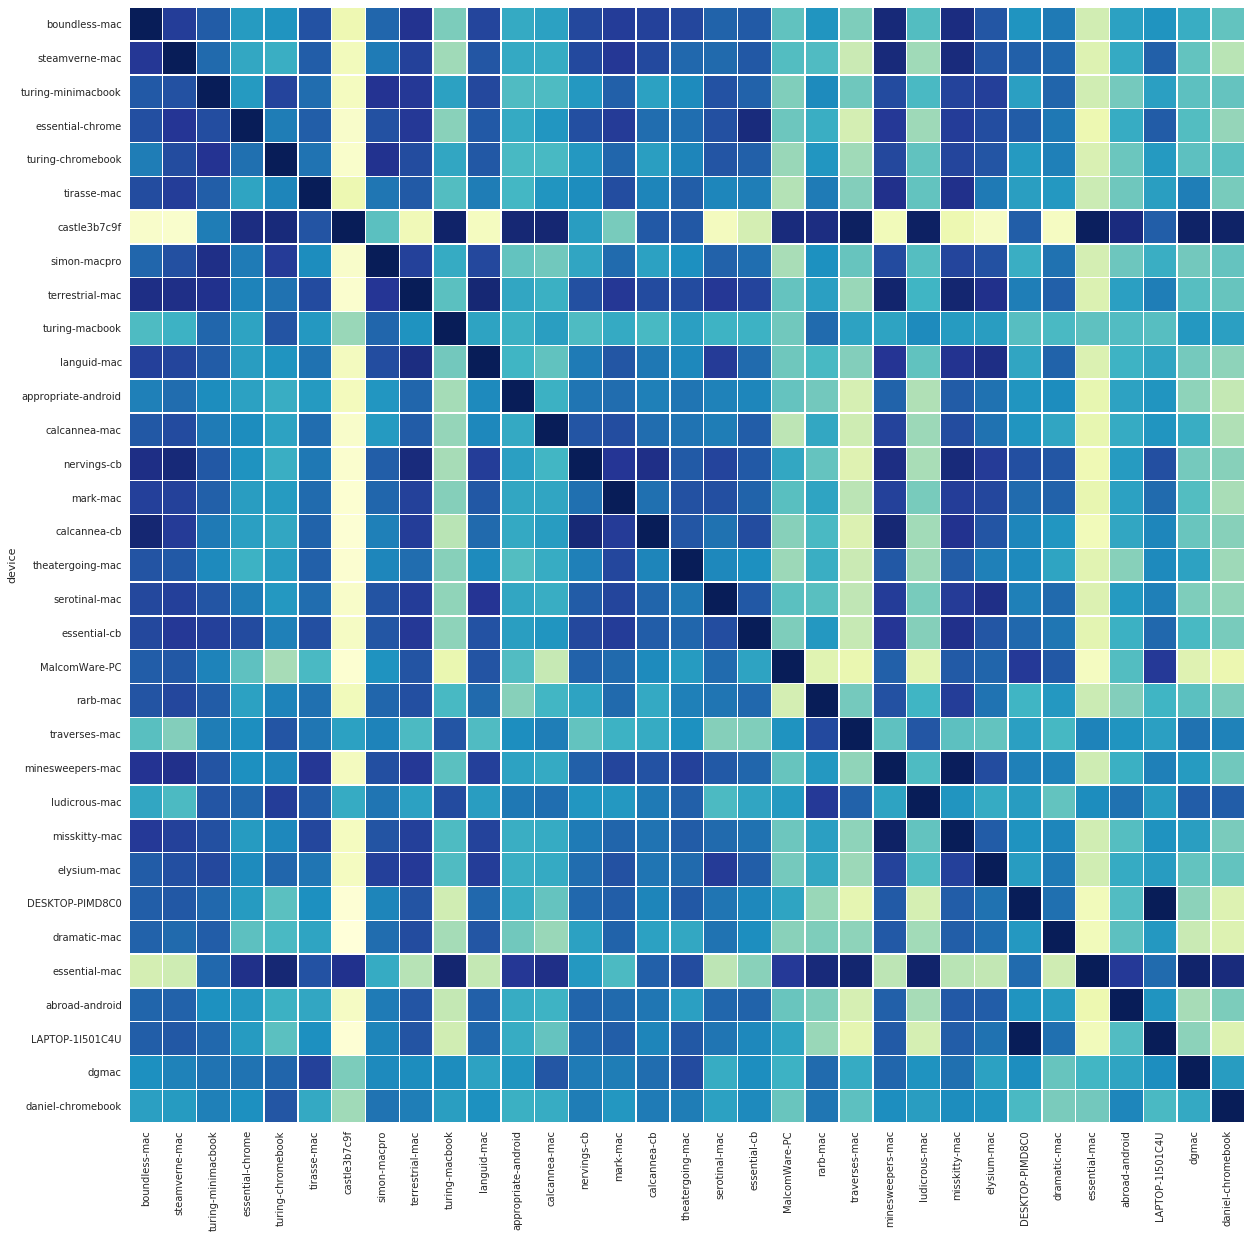

In [69]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df4[all_devices][all_devices], square=True, linewidths=0.5, cbar=False, cmap="YlGnBu")
plt.show()